# Support Vector Machine Classification - Articles Dataset

## Import Libraries 

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skopt import BayesSearchCV
from IPython.display import display, HTML
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.classifier.rocauc import roc_auc

show_html = lambda html: display(HTML(html))

## Import Dataset

In [5]:
with open("text", "r") as fp:
    text = json.load(fp)

with open("labels", "r") as fp:
    labels = json.load(fp)

In [6]:
len(text)

4000

In [7]:
len(labels)

4000

In [8]:
labels[11]

'astro-ph'

In [9]:
text[11]

"b'If dark matter (DM) is millicharged or darkly charged, collective plasma processes may dominate momentum exchange over direct particle collisions. In particular, plasma streaming instabilities can couple the momentum of DM to counter-streaming baryons or other DM and result in the counter-streaming fluids coming to rest with each other, just as happens for baryonic collisionless shocks in astrophysical systems. While electrostatic plasma instabilities (such as the two stream) are highly suppressed by Landau damping in the cosmological situations of interest, electromagnetic instabilities such as the Weibel can couple the momenta. Their growth rates are slower than the prior assumption that they would grow at the plasma frequency of DM. We find that the streaming of DM in the pre-Recombination universe is affected more strongly by direct collisions than collective processes, validating previous constraints. However, when considering unmagnetized instabilities the properties of the Bu

## Preprocessing

In [11]:
(X_train, X_test, y_train, y_test) = train_test_split(text, labels, test_size=0.3, random_state=42, stratify=labels)

In [12]:
len(X_train)

2800

In [13]:
len(X_test)

1200

## Text Labels to Numbers

In [15]:
label_encoder = LabelEncoder()
y_train_l = label_encoder.fit_transform(y_train)
y_test_l = label_encoder.fit_transform(y_test)
cls = label_encoder.inverse_transform(np.unique(y_train_l))

In [16]:
cls

array(['astro-ph', 'cs', 'math', 'physics'], dtype='<U8')

## Transformation to Data Matrix

In [18]:
voc_size = 1000
cvec = CountVectorizer(stop_words='english', max_features=voc_size, binary=True)
X_train_v = cvec.fit_transform(X_train)
X_test_v = cvec.transform(X_test)

In [19]:
X_train_v.shape

(2800, 1000)

In [20]:
X_test_v.shape

(1200, 1000)

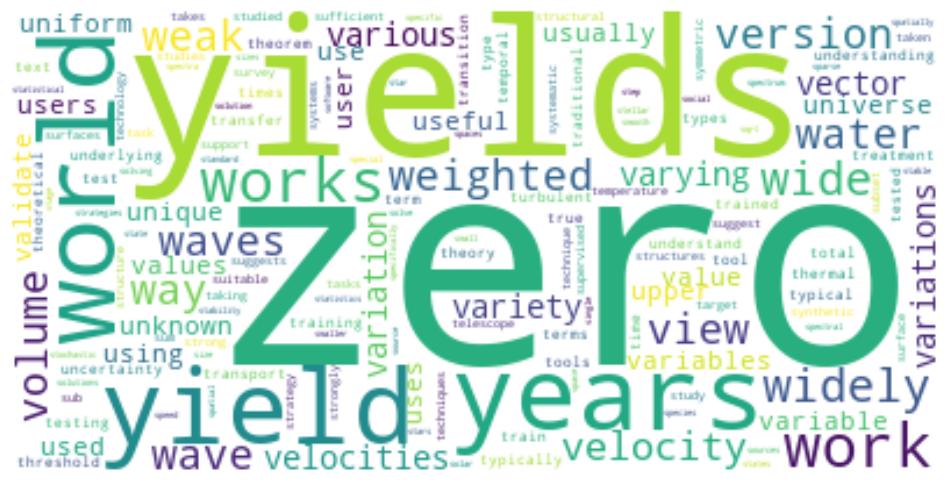

In [21]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(cvec.vocabulary_)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

## Dimensionality Reduction
### Principal Component Analysis

In [23]:
pca = PCA()

In [24]:
X_train_v_1 = np.array(X_train_v.todense())

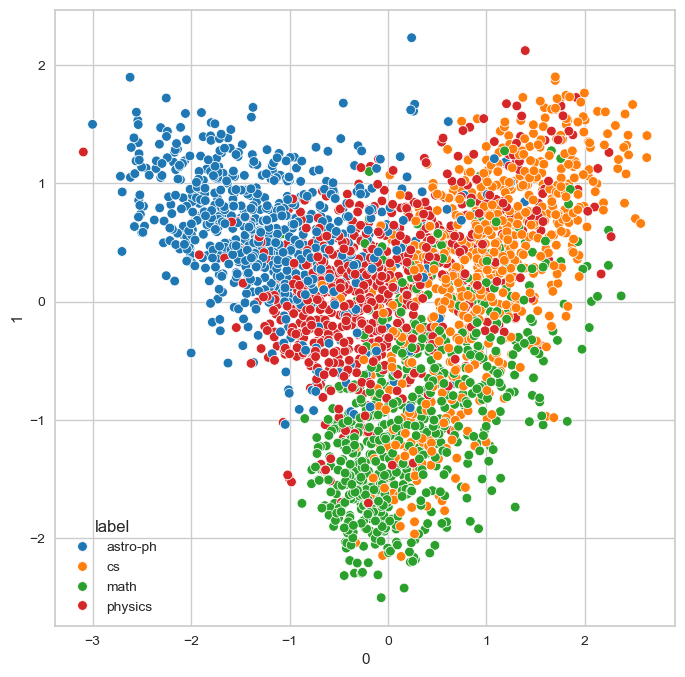

In [25]:
t_data = pca.fit_transform(X_train_v_1)
dfdata = pd.concat([pd.DataFrame(t_data[:,:2]), pd.DataFrame({'label':y_train})], axis=1) 
plt.figure(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

## SVM - Linear Kernel

In [27]:
param = {'C': 10**np.linspace(-3,3,101) }

In [28]:
lsvc = SVC(kernel='linear', max_iter=25000, random_state=0)

In [29]:
lsvc_search = BayesSearchCV(lsvc, param, n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=11)
lsvc_search.fit(X_train_v, y_train_l)

BayesSearchCV(cv=5,
              estimator=SVC(kernel='linear', max_iter=25000, random_state=0),
              n_iter=15, n_jobs=-1, random_state=11,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-0...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])})

In [30]:
show_html(pd.DataFrame(lsvc_search.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,{'C': 0.015848931924611134},0.783214,1
7,{'C': 0.004570881896148752},0.775714,2
11,{'C': 0.003019951720402016},0.772143,3
12,{'C': 0.03630780547701014},0.765000,4
0,{'C': 4.570881896148747},0.725714,5


### Classification Report

In [32]:
print(classification_report(lsvc_search.predict(X_test_v), y_test_l, target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.86      0.89      0.88       290
          cs       0.72      0.75      0.74       290
        math       0.79      0.73      0.76       324
     physics       0.71      0.72      0.71       296

    accuracy                           0.77      1200
   macro avg       0.77      0.77      0.77      1200
weighted avg       0.77      0.77      0.77      1200



### Confusion Matrix

In [34]:
y_pred = lsvc_search.predict(X_test_v)

In [35]:
cm = confusion_matrix(y_test_l, y_pred)

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)

<Figure size 2500x2500 with 0 Axes>

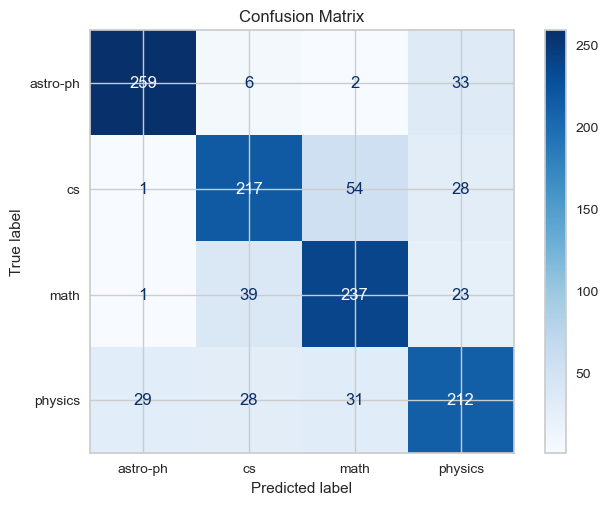

In [37]:
plt.figure(figsize=(10,10), dpi=250)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show();

### Roc Curve

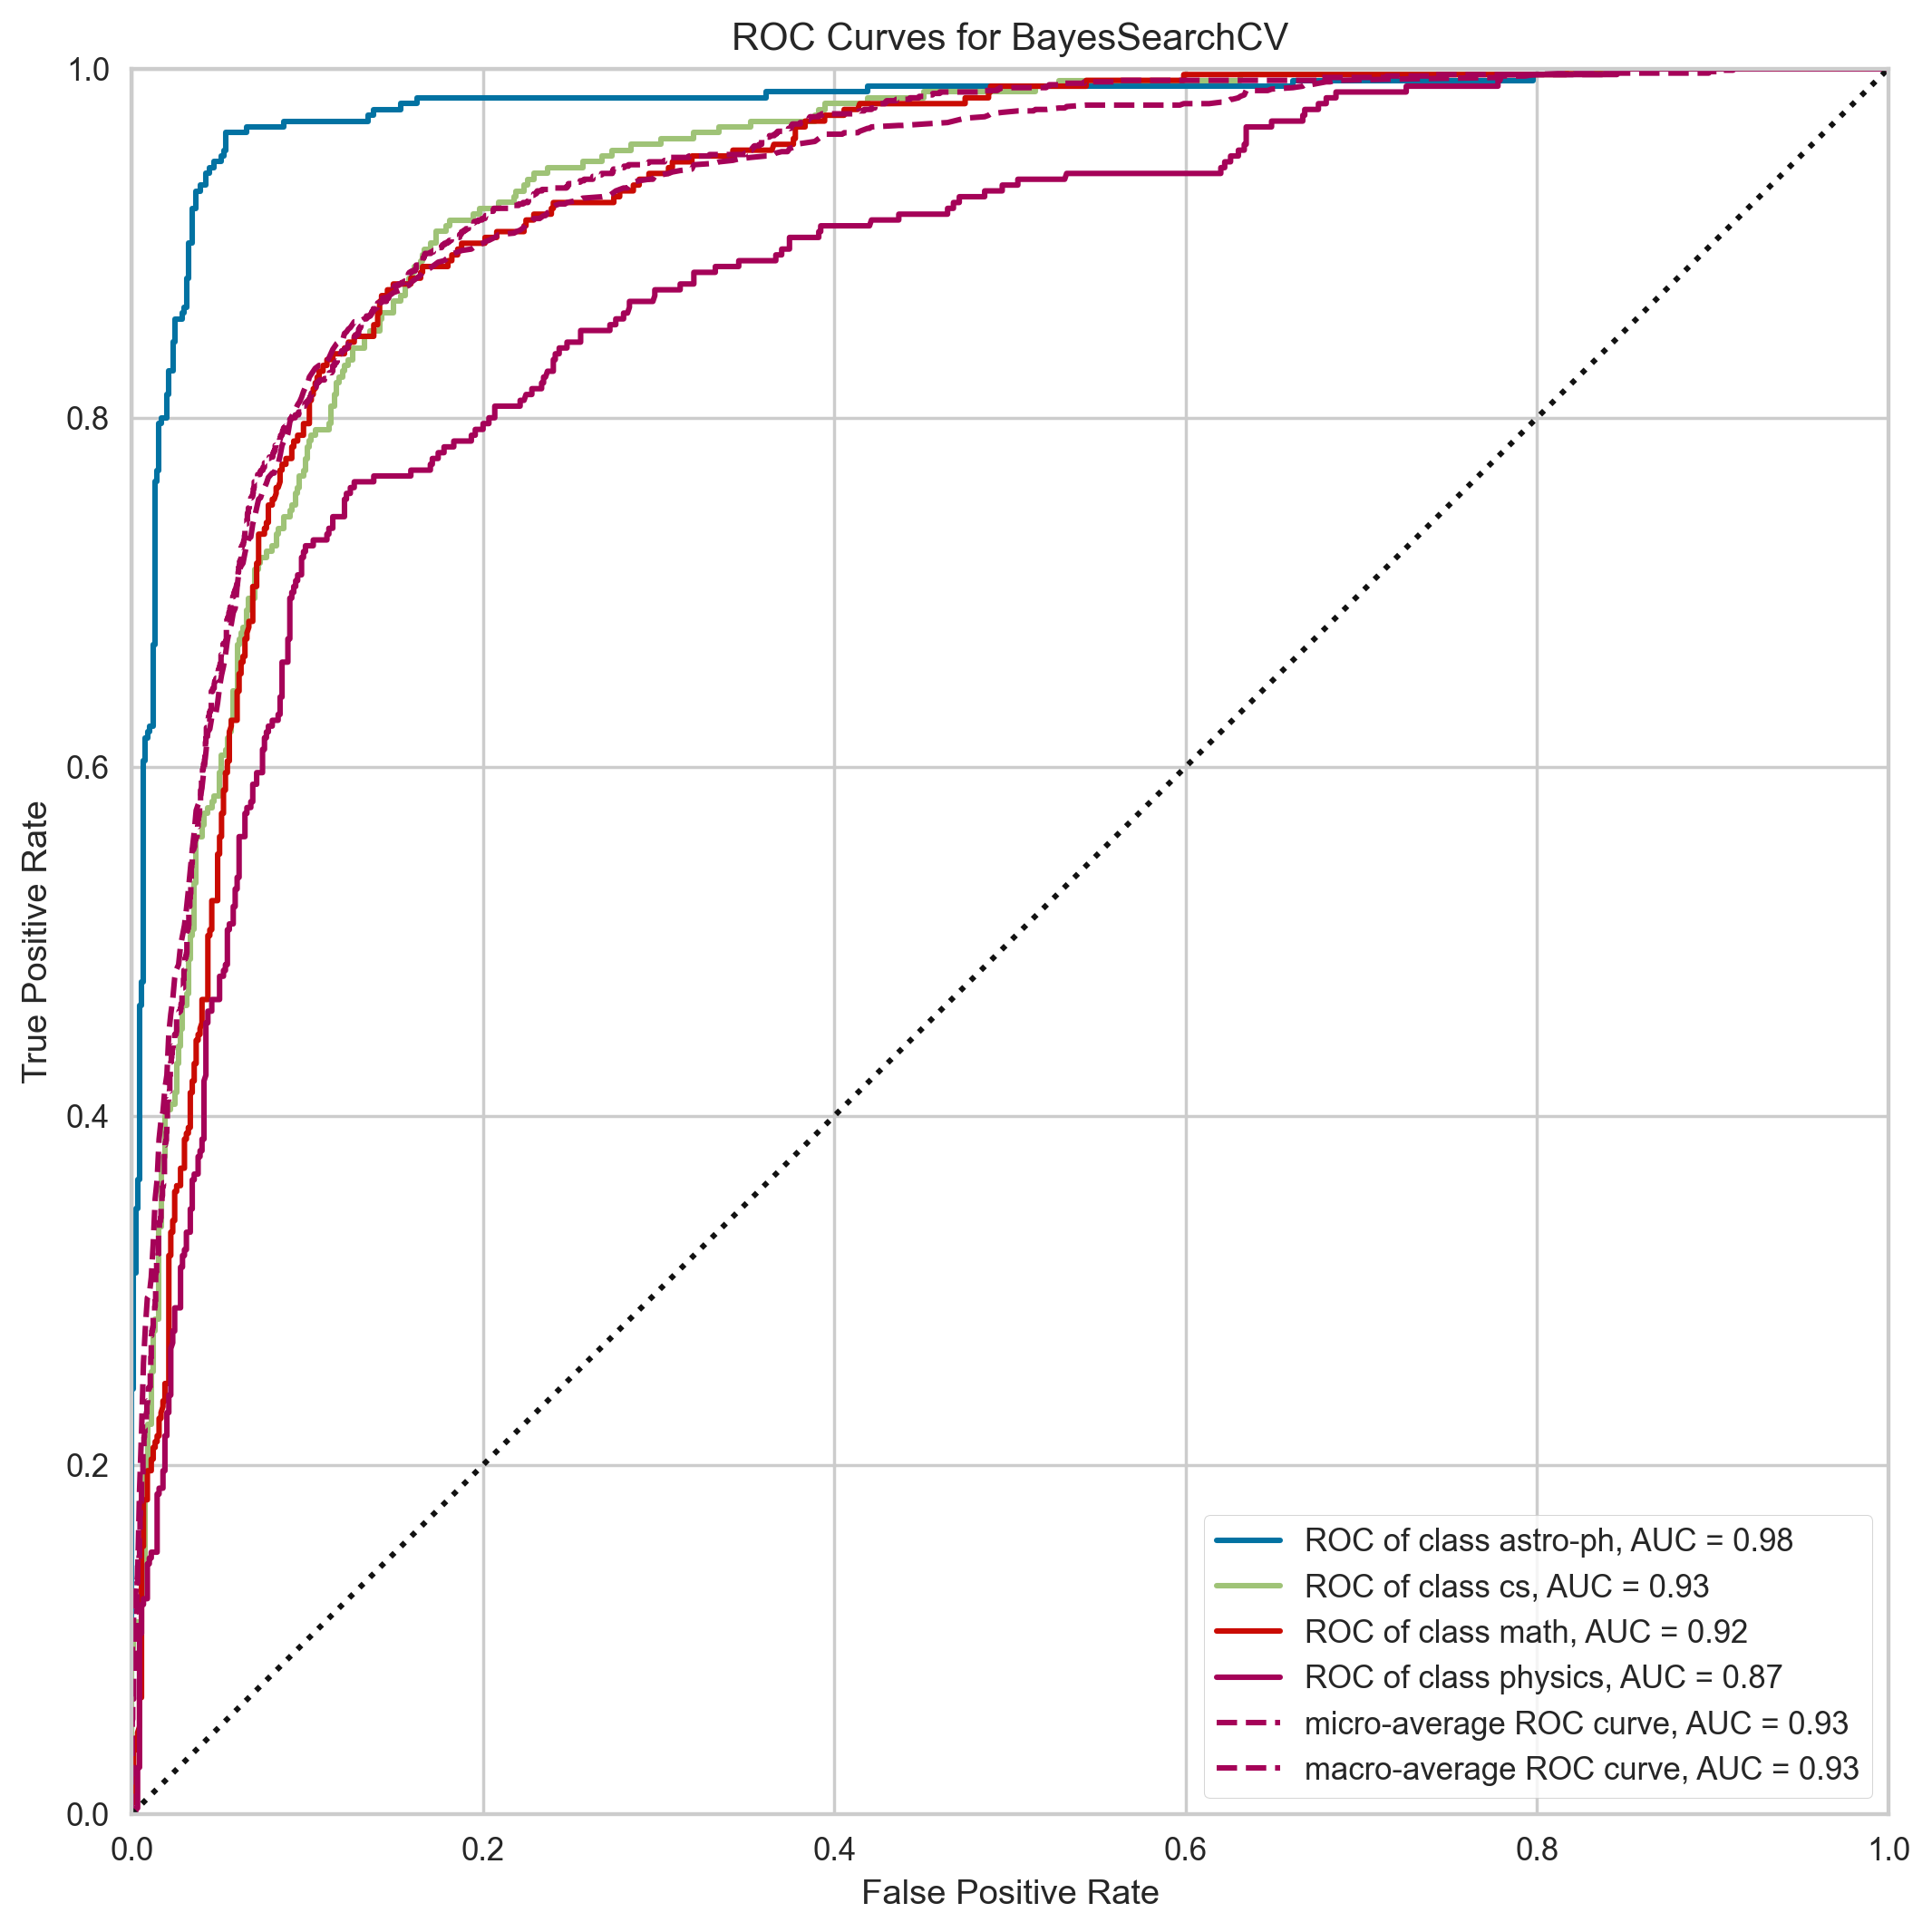

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=array(['astro-ph', 'cs', 'math', 'physics'], dtype='<U8'),
       estimator=BayesSearchCV(cv=5,
                               estimator=SVC(kernel='linear', max_iter=25000,
                                             random_state=0),
                               n_iter=15, n_jobs=-1, random_state=11,
                               search_spaces={'C': array([1.00000000e-03, 1.1481...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])}))

In [39]:
plt.figure(figsize=(10,10), dpi=250)
roc_auc(lsvc_search, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls)

## Polynomial Kernel

In [41]:
param = {'C': 10**np.linspace(-3,3,101), 'degree':[2,3] }
psvc = SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_search = BayesSearchCV(psvc, param, n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
psvc_search.fit(X_train_v, y_train_l)

C:\Users\South\AppData\Roaming\Python\Python312\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\South\AppData\Roaming\Python\Python312\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\South\AppData\Roaming\Python\Python312\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upco

BayesSearchCV(cv=5,
              estimator=SVC(kernel='poly', max_iter=25000, random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'degree': [2, 3]})

In [42]:
show_html(pd.DataFrame(psvc_search.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'C': 1.513561248436207, 'degree': 2}",0.785714,1
12,"{'C': 1.9952623149688788, 'degree': 2}",0.785000,2
13,"{'C': 2.6302679918953813, 'degree': 2}",0.784643,3
10,"{'C': 380.1893963205613, 'degree': 2}",0.781429,4
14,"{'C': 501.18723362727246, 'degree': 2}",0.781429,4


In [43]:
print(classification_report(psvc_search.predict(X_test_v), y_test_l, target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.86      0.91      0.88       281
          cs       0.73      0.76      0.74       289
        math       0.80      0.71      0.75       336
     physics       0.71      0.73      0.72       294

    accuracy                           0.77      1200
   macro avg       0.77      0.78      0.78      1200
weighted avg       0.77      0.77      0.77      1200



### Confusion Matrix

In [45]:
y_pred = psvc_search.predict(X_test_v)

In [46]:
cm = confusion_matrix(y_test_l, y_pred)

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)

<Figure size 2500x2500 with 0 Axes>

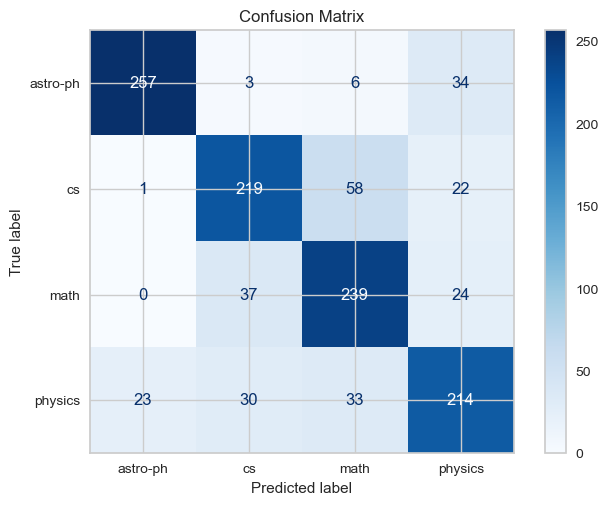

In [48]:
plt.figure(figsize=(10,10), dpi=250)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show();

### Roc Curve

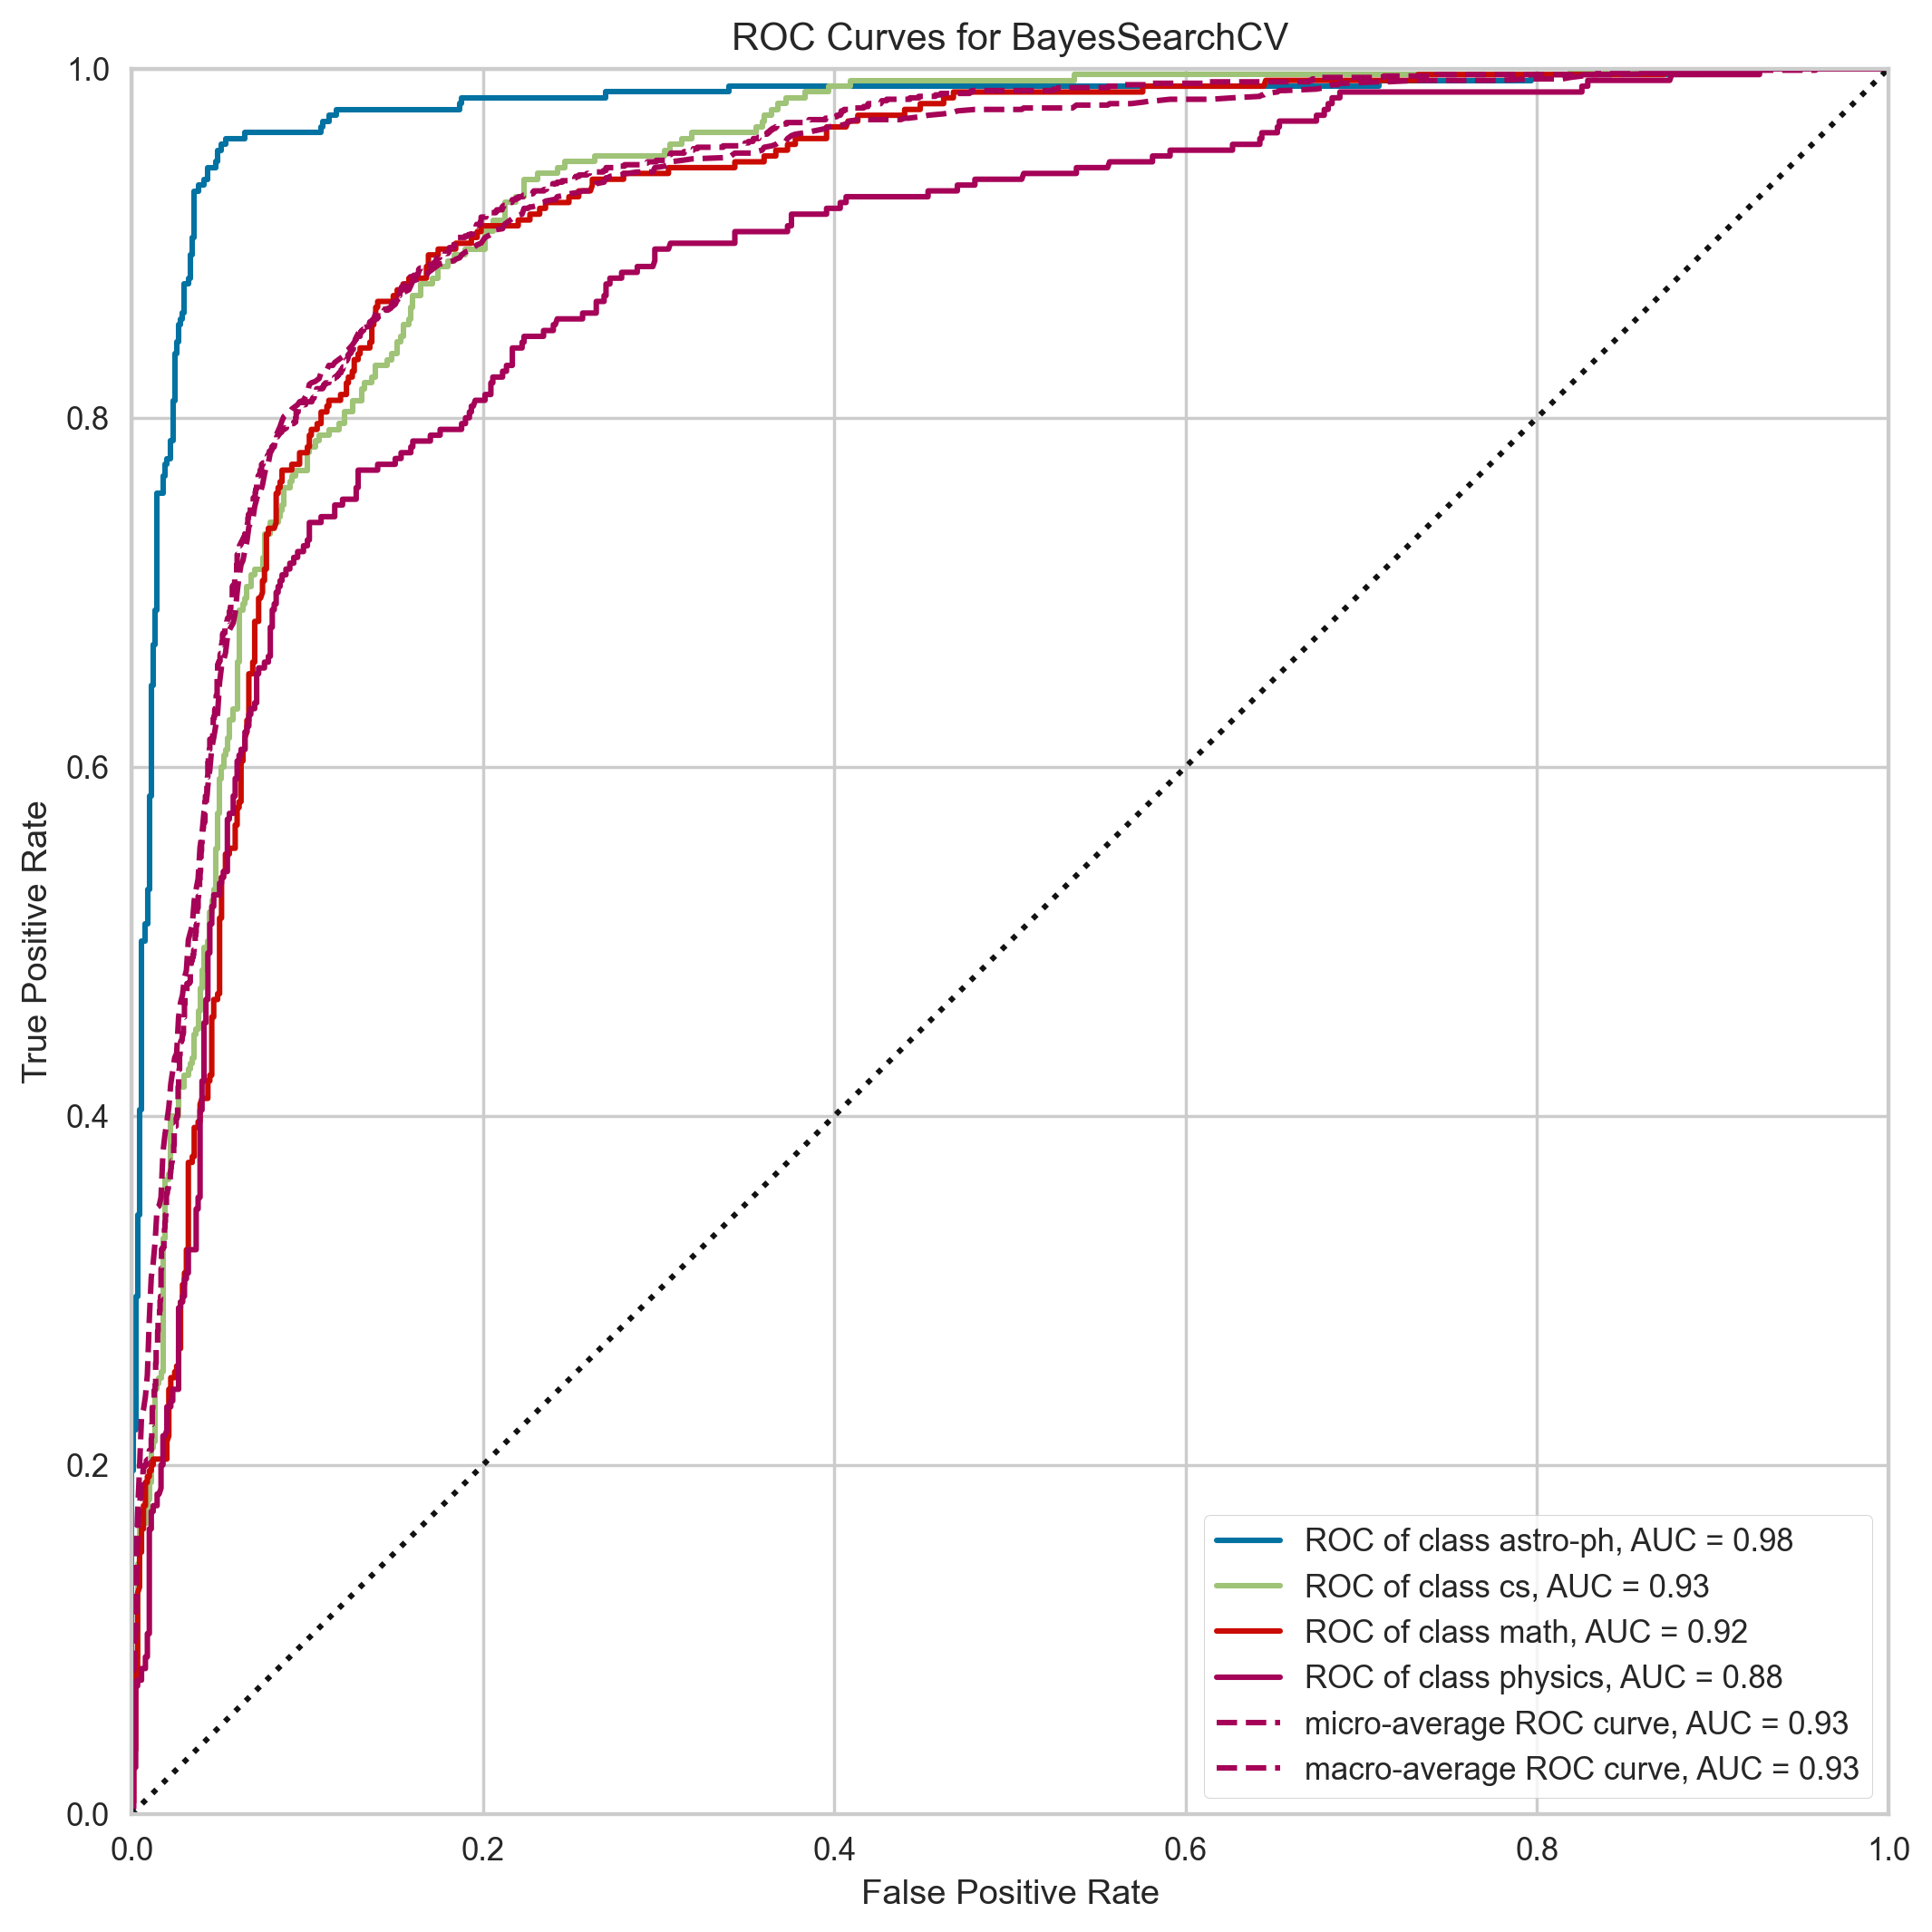

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=array(['astro-ph', 'cs', 'math', 'physics'], dtype='<U8'),
       estimator=BayesSearchCV(cv=5,
                               estimator=SVC(kernel='poly', max_iter=25000,
                                             random_state=0),
                               n_iter=15, n_jobs=-1, random_state=0,
                               search_spaces={'C': array([1.00000000e-03, 1.1481536...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                                              'degree': [2, 3]}))

In [50]:
plt.figure(figsize=(10,10), dpi=250)
roc_auc(psvc_search, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls)

## RBF Kernel

In [52]:
param = {'C': 10**np.linspace(-3,3,101), 'gamma':['scale', 'auto'] }
rbfsvc = SVC(kernel='rbf', max_iter=25000, random_state=0)
rbfsvc_search = BayesSearchCV(rbfsvc, param, n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
rbfsvc_search.fit(X_train_v, y_train_l)

BayesSearchCV(cv=5, estimator=SVC(max_iter=25000, random_state=0), n_iter=15,
              n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03,...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'gamma': ['scale', 'auto']})

In [53]:
show_html(pd.DataFrame(rbfsvc_search.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.791429,1
11,"{'C': 380.1893963205613, 'gamma': 'scale'}",0.789286,2
13,"{'C': 144.5439770745928, 'gamma': 'scale'}",0.789286,2
10,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.788929,4
0,"{'C': 1.513561248436207, 'gamma': 'auto'}",0.769286,5


In [54]:
print(classification_report(rbfsvc_search.predict(X_test_v), y_test_l, target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.88      0.91      0.90       289
          cs       0.76      0.76      0.76       300
        math       0.78      0.74      0.76       319
     physics       0.73      0.75      0.74       292

    accuracy                           0.79      1200
   macro avg       0.79      0.79      0.79      1200
weighted avg       0.79      0.79      0.79      1200



### Confusion Matrix

In [56]:
y_pred = rbfsvc_search.predict(X_test_v)

In [57]:
cm = confusion_matrix(y_test_l, y_pred)

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)

<Figure size 2500x2500 with 0 Axes>

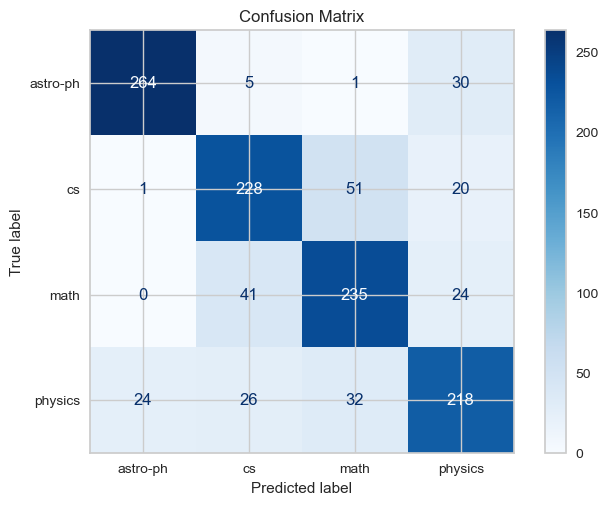

In [59]:
plt.figure(figsize=(10,10), dpi=250)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show();

### Roc Curve

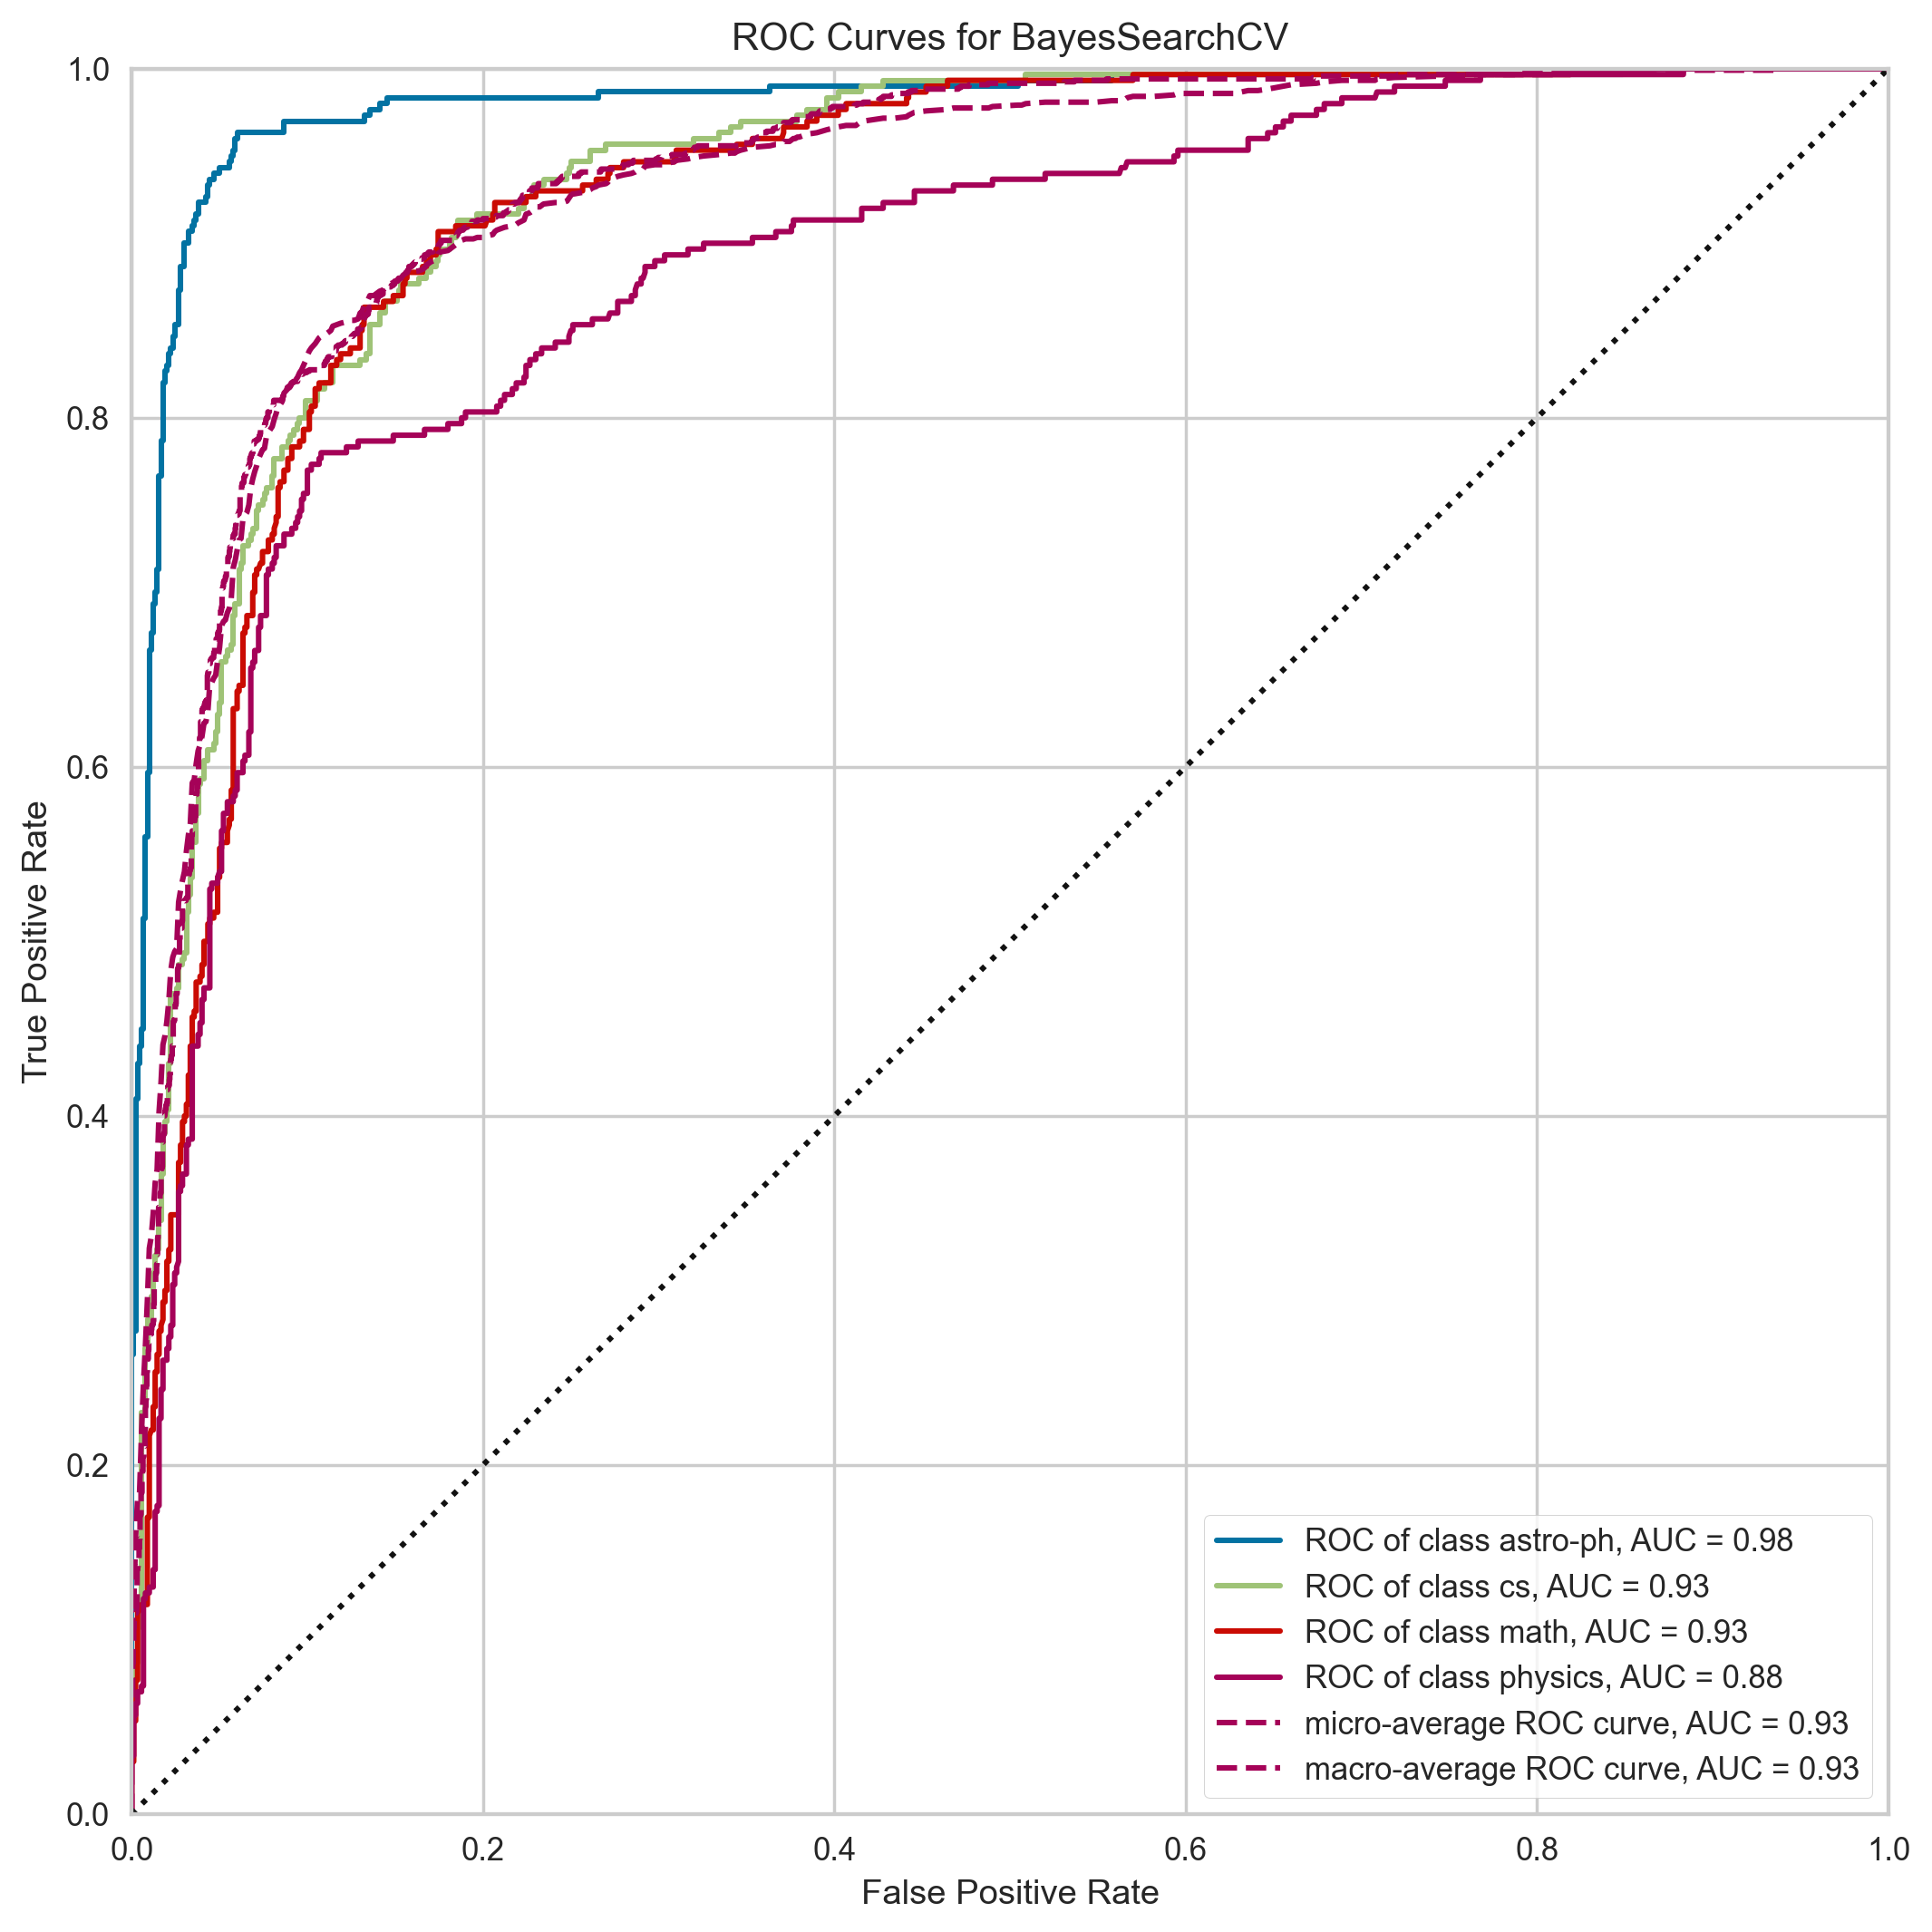

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=array(['astro-ph', 'cs', 'math', 'physics'], dtype='<U8'),
       estimator=BayesSearchCV(cv=5,
                               estimator=SVC(max_iter=25000, random_state=0),
                               n_iter=15, n_jobs=-1, random_state=0,
                               search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.318256...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                                              'gamma': ['scale', 'auto']}))

In [61]:
plt.figure(figsize=(10,10), dpi=250)
roc_auc(rbfsvc_search, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls)